# Analyzing Tennis Match Outcomes in the 2014 Grand Slams

Author: Arjun Dabir

Course Project, UC Irvine, Math 10, S24

I would like to post my notebook on the course's website. Yes

In [1]:
%pip install -q pandas ucimlrepo numpy matplotlib seaborn scikit-learn tensorflow

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

## Introduction

I am interested to see how player statistics during a game affect the player's overall outcome (if they win or lose). In this notebook, I analyze the outcomes of tennis matches in the 2014 Grand Slam tournaments. I use regression to predict continuous outcomes like total points won, and classification techniques, such as logistic regression and random forest classifiers, to predict match outcomes (win or lose).

The following 2 cells are imported directly from the ucimlrepo documentation.

In [3]:
tennis_data = fetch_ucirepo(id=300)

In [4]:
X = tennis_data.data.features
y = tennis_data.data.targets

I got this idea from [Stack Overflow](https://stackoverflow.com/questions/25351968/how-can-i-display-full-non-truncated-dataframe-information-in-html-when-conver) but I want to display all the columns of the dataset for visual purposes so I will use this line of code.

In [5]:
pd.set_option('display.max_columns', None)

For simplicity managing the data, I decided to concatenate the `X` and `y` onto one dataframe, with the `y` appended at the end

In [6]:
df = pd.concat([X, y], axis=1)
print(df.shape)
df.head()

(943, 43)


,Tournament,Player1,Player2,Round,FNL1,FNL2,FSP.1,FSW.1,SSP.1,SSW.1,ACE.1,DBF.1,WNR.1,UFE.1,BPC.1,BPW.1,NPA.1,NPW.1,TPW.1,ST1.1,ST2.1,ST3.1,ST4.1,ST5.1,FSP.2,FSW.2,SSP.2,SSW.2,ACE.2,DBF.2,WNR.2,UFE.2,BPC.2,BPW.2,NPA.2,NPW.2,TPW.2,ST1.2,ST2.2,ST3.2,ST4.2,ST5.2,Result
0,AusOpen-men,Lukas Lacko,Novak Djokovic,1,0.0,3.0,61,35,39,18,5.0,1.0,17.0,29.0,1.0,3.0,8.0,11.0,70.0,3.0,6.0,1.0,NaN,NaN,68,45,32,17,10.0,0.0,40.0,30.0,4.0,8.0,8.0,9.0,101.0,6.0,7.0,6.0,NaN,NaN,0
1,AusOpen-men,Leonardo Mayer,Albert Montanes,1,3.0,0.0,61,31,39,13,13.0,1.0,13.0,1.0,7.0,14.0,NaN,NaN,80.0,6.0,6.0,6.0,NaN,NaN,60,23,40,9,1.0,4.0,1.0,4.0,0.0,0.0,NaN,NaN,42.0,1.0,3.0,1.0,NaN,NaN,1
2,AusOpen-men,Marcos Baghdatis,Denis Istomin,1,0.0,3.0,52,53,48,20,8.0,4.0,37.0,50.0,1.0,9.0,16.0,23.0,106.0,4.0,5.0,4.0,NaN,NaN,77,57,23,15,9.0,1.0,41.0,41.0,4.0,13.0,12.0,16.0,126.0,6.0,7.0,6.0,NaN,NaN,0
3,AusOpen-men,Dmitry Tursunov,Michael Russell,1,3.0,0.0,53,39,47,24,8.0,6.0,8.0,6.0,6.0,9.0,NaN,NaN,104.0,6.0,6.0,6.0,NaN,NaN,50,24,50,19,1.0,8.0,1.0,8.0,1.0,7.0,NaN,NaN,79.0,2.0,2.0,3.0,NaN,NaN,1
4,AusOpen-men,Juan Monaco,Ernests Gulbis,1,1.0,3.0,76,63,24,12,0.0,4.0,16.0,35.0,3.0,12.0,9.0,13.0,128.0,6.0,4.0,6.0,2.0,NaN,53,59,47,32,17.0,11.0,59.0,79.0,3.0,5.0,16.0,28.0,127.0,1.0,6.0,7.0,6.0,NaN,0


### Preliminary Data Verification

The documentation noted that the Result is not denoted directly from match statistics from the game, but if `'Result1'` > `'Result2'`. To verify that `df` was created correctly, I will verify this claim by checking each row with this truth statement.

In [7]:
df.loc[(df["FNL1"] > df["FNL2"]) == df["Result"]].shape == df.shape

True

## Data Cleaning

I want to only analyze games that were completed because incomplete games have incomplete data and various extra data that could influence the score (injury, illness, etc.). First, I will look where there is no data (action done in the cell below) and filter further from there.

In [8]:
missing_values = df.isna().sum()
missing_values[missing_values > 0].shape, missing_values[missing_values > 0]

((30,),
 FNL1       1
 FNL2       1
 ACE.1     22
 DBF.1      8
 WNR.1    126
 UFE.1    126
 BPC.1      1
 BPW.1      1
 NPA.1     84
 NPW.1     83
 TPW.1    312
 ST1.1      1
 ST2.1      4
 ST3.1    321
 ST4.1    722
 ST5.1    857
 ACE.2     22
 DBF.2      8
 WNR.2    126
 UFE.2    126
 BPC.2      1
 BPW.2      1
 NPA.2     84
 NPW.2     83
 TPW.2    312
 ST1.2      1
 ST2.2      4
 ST3.2    321
 ST4.2    722
 ST5.2    857
 dtype: int64)

First, I want to observe the location where there was a missing data point of Final Number of Games Won by either Player 1 `'FNL.1'`, Player 2 `'FNL.2'`, or both.

In [9]:
df.loc[df["FNL1"].isna()]

,Tournament,Player1,Player2,Round,FNL1,FNL2,FSP.1,FSW.1,SSP.1,SSW.1,ACE.1,DBF.1,WNR.1,UFE.1,BPC.1,BPW.1,NPA.1,NPW.1,TPW.1,ST1.1,ST2.1,ST3.1,ST4.1,ST5.1,FSP.2,FSW.2,SSP.2,SSW.2,ACE.2,DBF.2,WNR.2,UFE.2,BPC.2,BPW.2,NPA.2,NPW.2,TPW.2,ST1.2,ST2.2,ST3.2,ST4.2,ST5.2,Result
170,AusOpen-women,Alize Cornet,Polona Hercog,1,NaN,NaN,75,3,25,1,1.0,NaN,2.0,0.0,NaN,NaN,1.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,0,0,100,1,0.0,NaN,1.0,1.0,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0


The `'FNL'` (Final Number of Games Won by Player(s))games were empty. After some [research online](https://tennistonic.com/tour-history/wta/7926/Polona-Hercog/Australian-Open---Melbourne/slam/), this appears to be a game where a player retired early. Futher, I found this was due to an [injury](https://tennistonic.com/tour-history/wta/7926/Polona-Hercog/Australian-Open---Melbourne/slam/). For incomplete matches, as they don't represent the full game of tennis, I will remove them.

### Identify if a Game is Not Completed:
*The official rules in GrandSlams state that men play up to 5 (first to 3) sets while women play up to 3 (first to 2)*

**Men's Tennis**: If at least 3 sets are not played

**Women's Tennis**: If at least 2 sets are not played


*The tournament is indicated with male or female using "-male" or "-female" but for organization and ease of use I will add 2 new features, `"Sex"`(string `"Male" | "Female"`) and a dummy variable `"isMale"` (boolean)*

In [10]:
df["Sex"] = df["Tournament"].apply(lambda tourna_name: "Female" if "women" in tourna_name else "Male")
df["isMale"] = pd.get_dummies(df["Sex"], drop_first=True)

Now, with the dummy variable and clear indentification if female or male, this following cell will find incomplete matches and remove them from the dataset

In [11]:
sets = ["ST1.1", "ST2.1", "ST3.1", "ST4.1", "ST5.1"]
incomplete_matches_id = df.loc[((df["isMale"] & (df[sets].notna().sum(axis=1) < 3)) | (~df["isMale"] & (df[sets].notna().sum(axis=1) < 2)))].index
print(len(incomplete_matches_id), incomplete_matches_id)

df.drop(index=incomplete_matches_id, inplace=True)
df.shape

11 Index([7, 15, 24, 40, 63, 170, 312, 344, 454, 455, 570], dtype='int64')


(932, 45)

We successfully removed 11 incomplete games indicated by the indices in the output cell.

### Removing Redundant Data

1. As we have `'FSP'` (First Serve Percentage for players), we don't need `'FSW'` (First Serve Won by players).
2. `'BPC'` (Break Points Created by players) and `'BPW'` (Break Points Won) can be added to a ratio `'BPP'` (Break Points Percentage)
3. Repeat 2. for `'NPA'` (Net Points Attempted) and `'NPW'` (Net Points Won)
4. Since we already have `'TPW'` (Total points won per player), rather than keeping the individual set scores in `'ST1'`- `'ST5'`. I plan on dropping the individual game information.

In [12]:
for i in [1,2]:
    # 2
    df[f"BPP.{i}"] = df.apply(lambda row: 0 if row[f"BPC.{i}"] == 0 else row[f"BPW.{i}"] / row[f"BPC.{i}"], axis=1)
    # 3
    df[f"NPP.{i}"] = df.apply(lambda row: 0 if row[f"NPA.{i}"] == 0 else row[f"NPW.{i}"] / row[f"NPA.{i}"], axis=1)
    # 4
    sets = [f"ST{j}.{i}" for j in range(1, 6)]
    # 1, 2, 3
    drop_features = [f"FSW.{i}", f"BPW.{i}", f"BPC.{i}", f"NPW.{i}", f"NPA.{i}"]

    for i in drop_features:
        sets.append(i)

    df.drop(columns=sets, inplace=True)
    df.head(1)

Now the data accurately represents all officially completed matches and relevant, non-redundant information. Next, there are various `NaN` values. With the assumption that the particular match did not reach the point of having this data (ex: a men's tennis match completing in 3 "straight" sets), I will replace these values with the value `0`.

In [13]:
df.fillna(0, inplace=True)

**Additional Removable Features**
1. `'Round'` - round the match is in
2. `'Player'` - competitor's full name

In [14]:
df.drop(columns=["Round", "Player1", "Player2"], inplace=True)

### Creating a Stratifiable Dummy Variable

As I conduct analysis and predictions with the dataset, I want to stratify the data equally for `'Sex'` and `'Tournaments'` for equal representation of two diverse contexts of the game.

In [15]:
df["Tournament"] = df["Tournament"].apply(lambda row: 1 if "AusOpen" in row else (2 if "FrenchOpen" in row else 3))

### Feature Organization

1. Put `'Result'` at the end of the dataframe.
2. Move `'Sex'` and `'isMale'` as the first 2 features

In [16]:
def move_column(df, left_col, right_col):
    cols = df.columns.tolist()
    cols.insert(cols.index(right_col), cols.pop(cols.index(left_col)))
    return df[cols]

In [17]:
cols_to_move = [["Result", "NPP.2"], ["Sex", "FNL1"], ["isMale", "FNL1"]]
for cols in cols_to_move:
    df = move_column(df, cols[0], cols[1])

This is a final representation of the cleaned and reorganized dataframe, `df`

In [18]:
df.head(5)

,Tournament,Sex,isMale,FNL1,FNL2,FSP.1,SSP.1,SSW.1,ACE.1,DBF.1,WNR.1,UFE.1,TPW.1,FSP.2,SSP.2,SSW.2,ACE.2,DBF.2,WNR.2,UFE.2,TPW.2,BPP.1,NPP.1,BPP.2,NPP.2,Result
0,1,Male,True,0.0,3.0,61,39,18,5.0,1.0,17.0,29.0,70.0,68,32,17,10.0,0.0,40.0,30.0,101.0,3.0,1.375000,2.000000,1.125000,0
1,1,Male,True,3.0,0.0,61,39,13,13.0,1.0,13.0,1.0,80.0,60,40,9,1.0,4.0,1.0,4.0,42.0,2.0,0.000000,0.000000,0.000000,1
2,1,Male,True,0.0,3.0,52,48,20,8.0,4.0,37.0,50.0,106.0,77,23,15,9.0,1.0,41.0,41.0,126.0,9.0,1.437500,3.250000,1.333333,0
3,1,Male,True,3.0,0.0,53,47,24,8.0,6.0,8.0,6.0,104.0,50,50,19,1.0,8.0,1.0,8.0,79.0,1.5,0.000000,7.000000,0.000000,1
4,1,Male,True,1.0,3.0,76,24,12,0.0,4.0,16.0,35.0,128.0,53,47,32,17.0,11.0,59.0,79.0,127.0,4.0,1.444444,1.666667,1.750000,0


## Data Exploring

Using visualizations like correlation heatmaps and scatter plots to understand the relationships between different performance metrics and match outcomes. By analyzing these patterns, I aim to uncover significant factors that influence match results and provide insights into player performance.

### Correlation Heatmap

I will create a correlation map with relevant data in a tennis game `[FNL1 - Result]` to identify unique/interesting correlations.

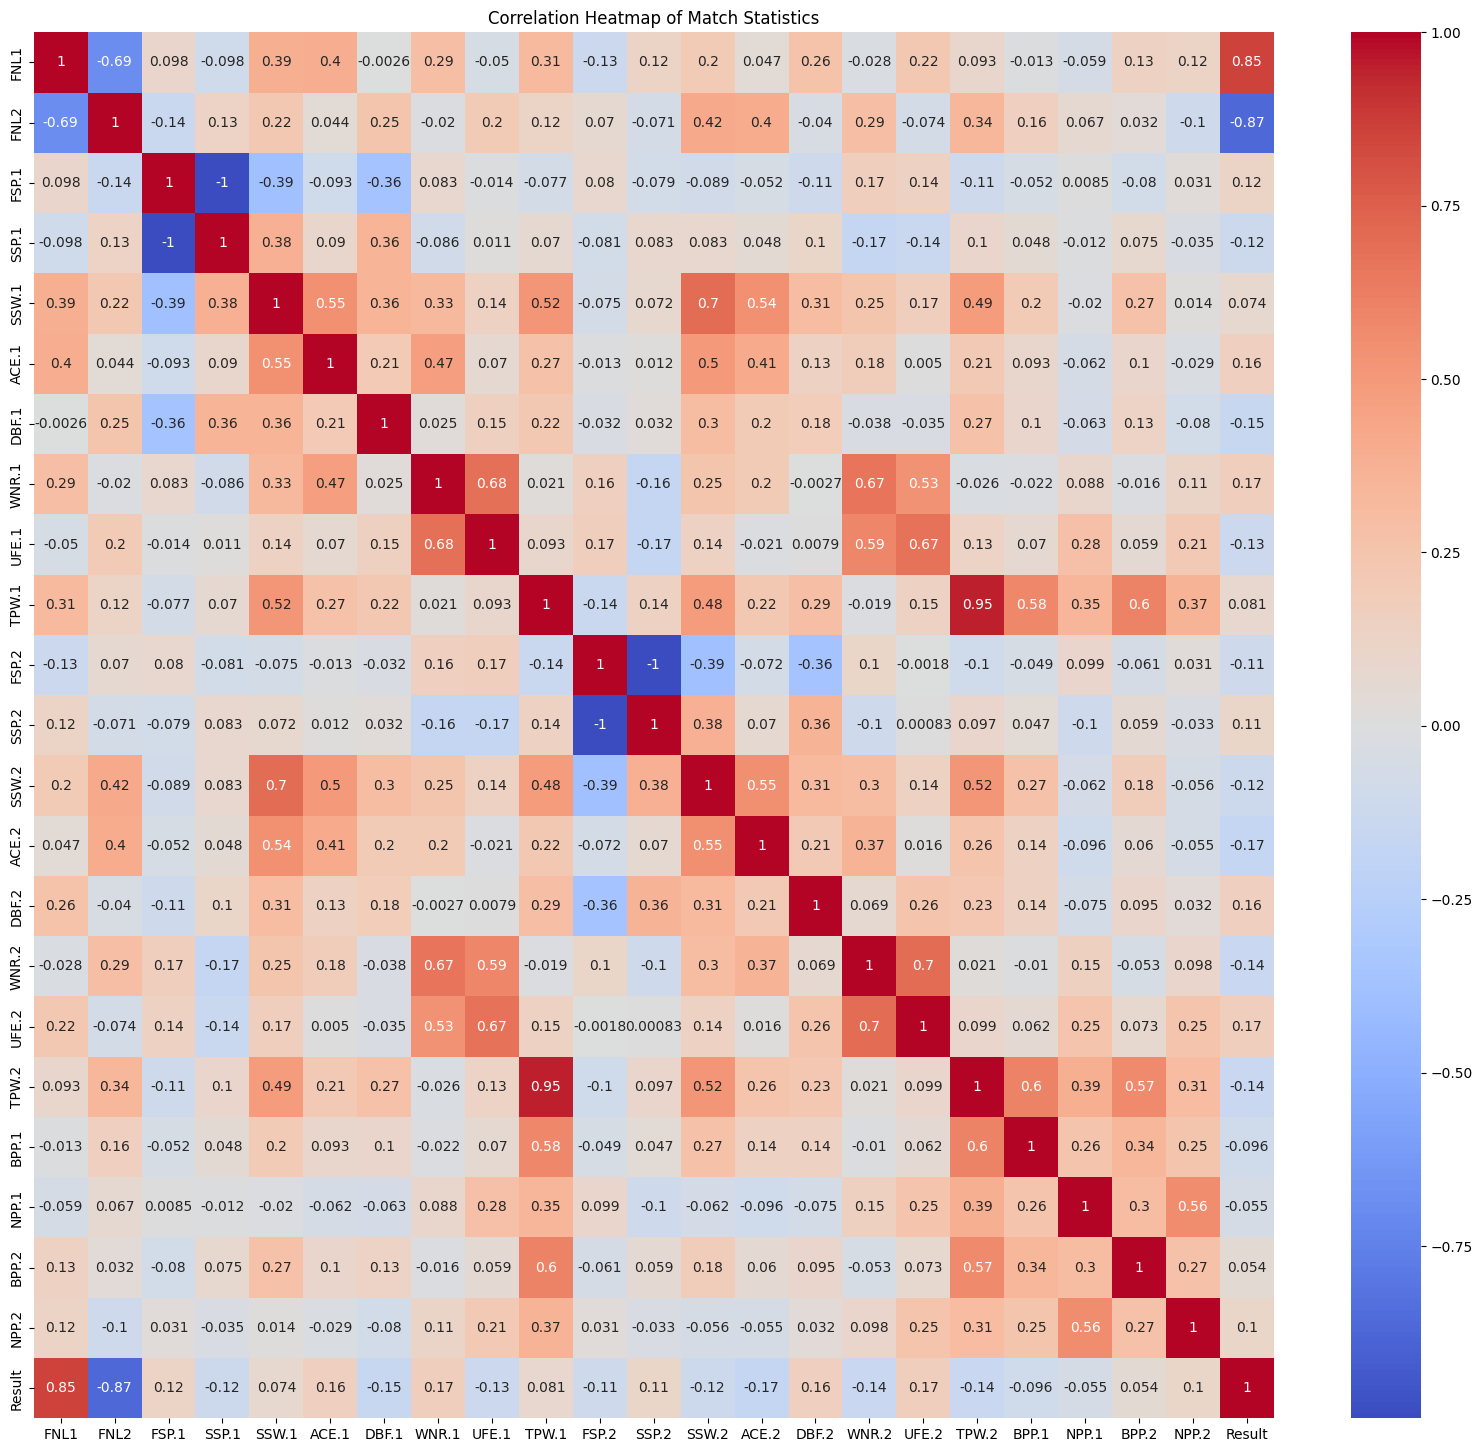

In [19]:
plt.figure(figsize=(20, 18))
sns.heatmap(df.loc[:, "FNL1":"Result"].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Match Statistics')
plt.show()

### Removing Possibly Invalid Data

Apart from the main diagonal which shows an exact correlation between the variables (since they are the same) there were 2 others that marked a -1, perfect negative correlation.

This was between:

`"FSP.1"` and `"SSP.1"` (First Serve Percentage and Second Serve Percentage for Player 1)

`"FSP.2"` and `"SSP.2"` (First Serve Percentage and Second Serve Percentage for Player 2)

After inspection of the dataframe from a previous output, the percentage of these features added together always is 100, which is particularly odd.

Since these are the equations to get FSP and SSP:

  $$
  \text{FSP} = \frac{\text{Number of First Serves In}}{\text{Number of First Serve Attempts}} \times 100
  $$

  $$
  \text{SSP} = \frac{\text{Number of Second Serves In}}{\text{Number of Second Serve Attempts}} \times 100
  $$

These equations aren't related at all even though the second serve occurs directly after a missed first serve. However, with this odd high negative correlation. Due to this odd correlation, I will drop both values since I can't conclude if they are accurately denoted.

In [20]:
df.drop(columns=["FSP.1", "SSP.1", "FSP.2", "SSP.2"], inplace=True)

There are several interesting correlations to analyze.

**High Positive Correlations**
1. `'TPW.1'` and `'TPW.2'`, `r = 0.95`
2. `'FNL.1'` and `'Result'`, `r = 0.85`
3. `'SSW.1'` and `'SSW.2'`, `r = 0.7`
4. `'WNR.2'` and `'UFE.2'`, `r = 0.7`
5. `'WNR.1'` and `'UFE.1'`, `r = 0.68`

**High Negative Correlations**
1. `'FNL.2'` and `'Result'`, `r = -0.87`
2. `'FNL.1'` and `'FNL.2'`, `r = -0.69`

*However, as the 'FNL' features have a domain [0, 3], these values are likely influenced by the limited range of possible outcomes. This could give a perception of the strength.*

### Visualizing the Data

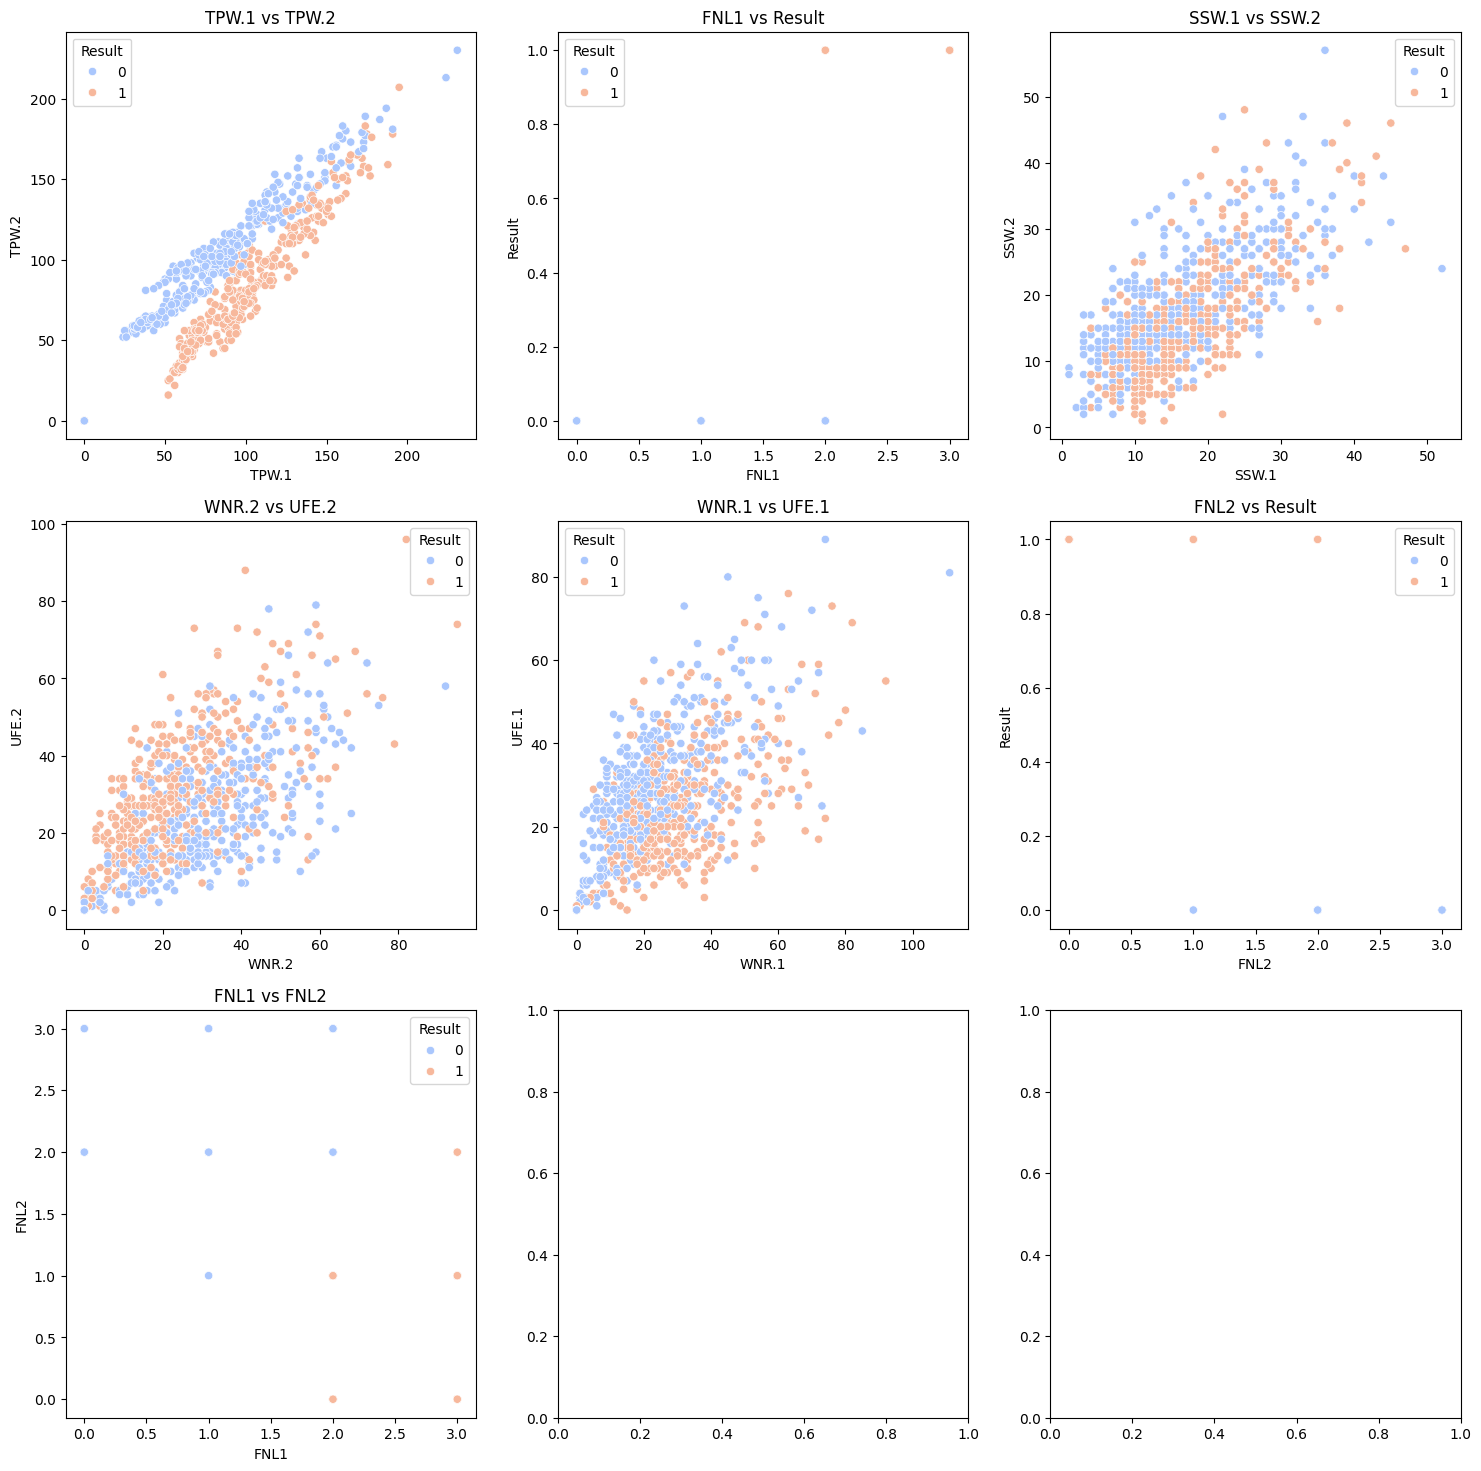

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

corr_data = [["TPW.1", 'TPW.2'], ['FNL1','Result'], ['SSW.1','SSW.2' ], ['WNR.2','UFE.2'], ['WNR.1','UFE.1'], ['FNL2', 'Result'], ["FNL1", "FNL2"]]

index = 0
i = 0
j = 0

while index < len(corr_data):
    sns.scatterplot(x=corr_data[index][0], y=corr_data[index][1], hue='Result',
                    data=df, ax=axes[i, j], palette='coolwarm')
    axes[i, j].set_title(f'{corr_data[index][0]} vs {corr_data[index][1]}')
    axes[i, j].set_xlabel(f'{corr_data[index][0]}')
    axes[i, j].set_ylabel(f'{corr_data[index][1]}')

    j+=1

    if j > 2:
        j = 0
        i+=1

    index+=1

plt.show()

The results from `'FNL.1'` and `'Result'`, `'FNL.2'` and `'Result'`, and `'FNL.1'` and `'FNL.2'` show the colinearity since ${FNL1} > {FNL2}={Result}$. For the other correlations they all to have a positive correlation while slightly increasing variability as we get to bigger values(other than `'TPW.1'` and `'TPW.2'`, it maintained relatively the same variability).

## Data Analysis

### Logistic Regression for Binary Classification

The comparison between `'WNR.2'` and `'UFE.2'` as well as `'WNR.1'` and `'UFE.1'` seem interesting. I want to investigate whether the relationships between winners and unforced errors for both players have any significant influence on predicting the match outcome `'Result'`

#### Combining Winners and Unforced Errors

Since we are analyzing how winners and unforced errors predict the chance of winning, I will take the difference of the each category, in subject of `'Player1'` (for continuity since the Result is in reference of Player 1 as well). These new features, `'WIND'` (Winners Difference) and `'UFED'` (Unforced Errors Difference), for my binary classification.

In [22]:
df["WIND"] = df["WNR.1"] - df["WNR.2"]
df["UFED"] = df["UFE.1"] - df["UFE.2"]

features = ["WIND", "UFED"]
result = "Result"

Using my function `move_columns()` I will move these before the Result for organizational purposes.

In [23]:
new_cols = [["WIND", "Result"], ["UFED", "Result"]]
for cols in new_cols:
    df = move_column(df, cols[0], cols[1])

### Scaling my Dataset (part 1)
I want to scale my entire dataset since I will using it for future cases. By scaling everything so I don't have to repeat this process in future cells. However, I don't scale `'TPW.1'` for my regression analysis below, but conclude this scaling process after that.

In [24]:
relevant_cols = [col for col in df.loc[:, 'FNL1':'NPP.2'].columns if col != 'TPW.1']

scaler = StandardScaler()
df[relevant_cols] = scaler.fit_transform(df[relevant_cols])

X = df[features]
y = df[result]

#### Fitting the Linear Regression Model

In [25]:
stratify = ["Sex", "Tournament"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=df[stratify])

model = LogisticRegression(penalty=None, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty=None)

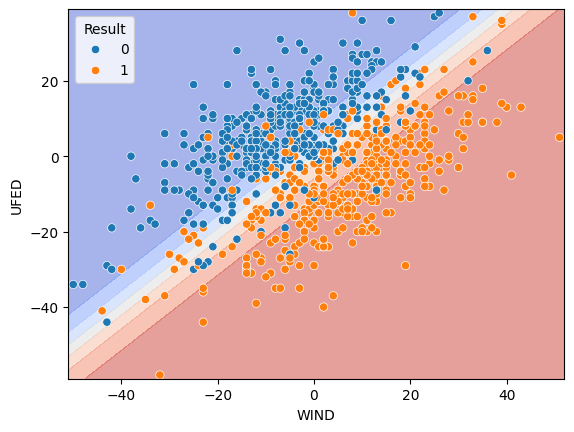

In [26]:
fig, ax = plt.subplots()

db_display = DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    grid_resolution=200,
    response_method="predict_proba",
    cmap='coolwarm',
    alpha=0.5,
    ax=ax
)

scatter = sns.scatterplot(
    data=df, x=df[features[0]], y=df[features[1]], hue='Result')
plt.show()

In [27]:
score_train = model.score(X_train, y_train)
score_test = model.score(X_test, y_test)
print(f"Training accuracy: {score_train:.2f}")
print(f"Test accuracy: {score_test:.2f}")

Training accuracy: 0.84
Test accuracy: 0.82


In addition to visualizing the boundary and the accuracy, I want to see all number of prediction that were true-positives/negatives and false-positives/negatives in the context of this data set.

Confusion Matrix:
 [[80 10]
 [24 73]]


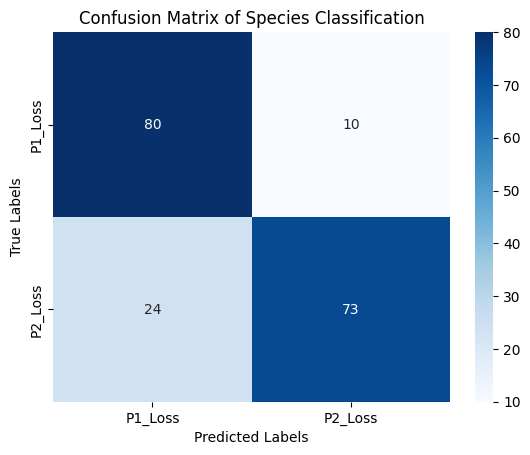

In [28]:
y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['P1_Loss', 'P2_Loss'], yticklabels=['P1_Loss', 'P2_Loss'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of Species Classification')
plt.show()

In [29]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(
    model, df[features], df[result], cv=kf, scoring='accuracy')

print("Accuracy scores for each fold:", scores)
print("Average accuracy score:", scores.mean())
print("Standard deviation of accuracy scores:", scores.std())

Accuracy scores for each fold: [0.8342246  0.80748663 0.80107527 0.88172043 0.80645161]
Average accuracy score: 0.8261917083548962
Standard deviation of accuracy scores: 0.030061114723923615


I can't conclude that the winners and unforced errors can predit the classification of a win or loss for players but they had a relatively high score and accuracy.

## Regression Models

I am interested to see if `'Player 1'` performance could predict their total points won `'TPW'`.

In [30]:
features = ['ACE.1', 'DBF.1', 'WNR.1', 'UFE.1', 'SSW.1']
target = 'TPW.1'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=df[stratify])
def reg_model(model):


    model.fit(X_train, y_train)

    # got this from https://stackoverflow.com/questions/52763325/how-to-obtain-only-the-name-of-a-models-object-in-scikitlearn
    print(f"Model: {model.__class__.__name__}")

    print(f"Intercept: {model.intercept_}")
    print(f"R^2 Score: {model.score(X_test, y_test)}")

In [31]:
models = [LinearRegression(), Lasso(), Ridge()]
for model in models:
    reg_model(model)

Model: LinearRegression
Intercept: 62.66499544683466
R^2 Score: 0.32456458679267197
Model: Lasso
Intercept: 62.83830252196165
R^2 Score: 0.3182726566437233
Model: Ridge
Intercept: 62.66946411404868
R^2 Score: 0.3245041539117738


Despite preventing overfitting with Ridge and Lasso Regression, it still seems that the correlation is low. I can't conclude that there is a relationship between the overall performance of `'Player 1'` with the total point won.

### Finishing Scaling
Scaling `'TPW.1'` now for future analysis.

In [32]:
target = "TPW.1"
df[target] = scaler.fit_transform(df[[target]])
df.head()

,Tournament,Sex,isMale,FNL1,FNL2,SSW.1,ACE.1,DBF.1,WNR.1,UFE.1,TPW.1,SSW.2,ACE.2,DBF.2,WNR.2,UFE.2,TPW.2,BPP.1,NPP.1,BPP.2,NPP.2,WIND,UFED,Result
0,1,Male,True,-1.292042,1.278539,0.137015,-0.171029,-0.989564,-0.391497,0.318374,0.124982,-0.004063,0.683308,-1.370219,0.902713,0.343717,0.694340,0.733311,0.309997,0.145321,-0.029631,-23.0,-1.0,0
1,1,Male,True,1.299457,-1.280370,-0.445018,1.169867,-0.989564,-0.616312,-1.392909,0.311148,-0.922077,-0.809682,0.088010,-1.328928,-1.166792,-0.398370,0.138486,-1.652745,-1.066980,-1.541314,12.0,-3.0,1
2,1,Male,True,-1.292042,1.278539,0.369828,0.331807,0.137910,0.732579,1.601836,0.795177,-0.233567,0.517421,-1.005662,0.959935,0.982778,1.157352,4.302261,0.399213,0.903009,0.250311,-4.0,9.0,0
3,1,Male,True,1.299457,-1.280370,0.835455,0.331807,0.889559,-0.897330,-1.087323,0.757944,0.225440,-0.809682,1.546240,-1.328928,-0.934406,0.286889,-0.158927,-1.652745,3.176074,-1.541314,7.0,-2.0,1
4,1,Male,True,-0.428209,1.278539,-0.561424,-1.009089,0.137910,-0.447700,0.685077,1.204741,1.717213,1.844523,2.639912,1.989924,3.190446,1.175873,1.328136,0.409126,-0.056729,0.810194,-43.0,-44.0,0


## Reducing Dimensionality

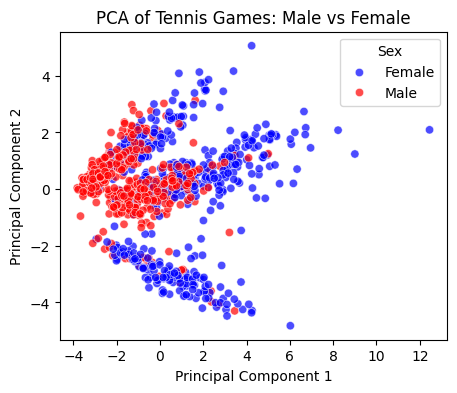

In [33]:
cols = ["FNL1", "FNL2", "SSW.1", "ACE.1", "DBF.1", "WNR.1", "UFE.1", "TPW.1", "SSW.2", "ACE.2", "DBF.2", "WNR.2", "UFE.2", "TPW.2", "BPP.1", "NPP.1", "BPP.2", "NPP.2"]

df['Sex'] = df['Sex'].map({"Male": 1, "Female": 0})
sex = df['Sex']

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df[cols])

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Sex'] = sex

plt.figure(figsize=(5, 4))
sns.scatterplot(x='PC1', y='PC2', hue='Sex', data=pca_df, palette={1: 'blue', 0: 'red'}, alpha=0.7)
plt.title('PCA of Tennis Games: Male vs Female')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Sex', labels=['Female', 'Male'])
plt.show()

There appears to be a distinction between the upper group of men's vs. women's matches as the men's matches are more negative in the PCA 1 and near 0 for PCA 2. However, there is no clear distinction between the sex and the features in a game.

## Extra: Random Forest Classifier

I was introduced to the concept of Random Forest Classifiers by this [Youtube Video](https://www.youtube.com/watch?v=gkXX4h3qYm4) and want to use it to improve my prediction of my original analysis of analyzing match outcomes of the players in a singles match. The rest of the code was using their [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

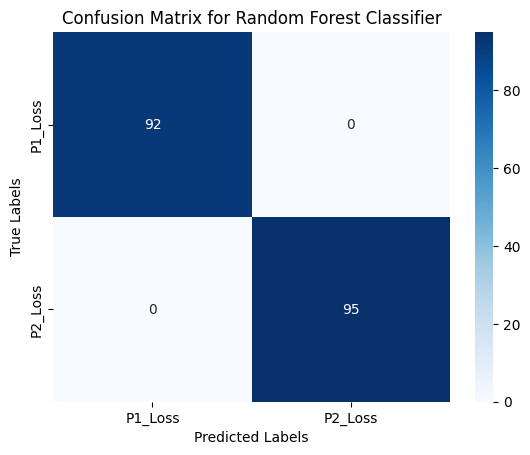

Random Forest Accuracy scores for each fold: [1. 1. 1. 1. 1.]
Average accuracy score: 1.0
Standard deviation of accuracy scores: 0.0


In [34]:
features = ["FNL1", "FNL2", "SSW.1", "ACE.1", "DBF.1", "WNR.1", "UFE.1", "TPW.1",
               "SSW.2", "ACE.2", "DBF.2", "WNR.2", "UFE.2", "TPW.2",
               "BPP.1", "NPP.1", "BPP.2", "NPP.2"]
target = "Result"

X_rf = df[features]
y_rf = df[target]

X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=0, stratify=df['Sex'])

rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_rf_train, y_rf_train)

y_rf_pred = rf_model.predict(X_rf_test)
rf_accuracy = accuracy_score(y_rf_test, y_rf_pred)
print(f'Random Forest Accuracy: {rf_accuracy*100}%')

conf_matrix_rf = confusion_matrix(y_rf_test, y_rf_pred)
print("Confusion Matrix:\n", conf_matrix_rf)

sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['P1_Loss', 'P2_Loss'], yticklabels=['P1_Loss', 'P2_Loss'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

rf_kf = KFold(n_splits=5, shuffle=True, random_state=1)
rf_scores = cross_val_score(rf_model, X_rf, y_rf, cv=rf_kf, scoring='accuracy')

print("Random Forest Accuracy scores for each fold:", rf_scores)
print("Average accuracy score:", rf_scores.mean())
print("Standard deviation of accuracy scores:", rf_scores.std())

There is a perfect accuracy represented by this classifier. This could represent overfitting but extending off my introduction to this topic, this is a very interesting (and potentially accurate) classifier that I could use when developing future models. I would have to use more data from not just Grand Slams but ATP Matches and WTA matches to add to this data and test the data.

## Extra: Neural Networks
After learning about neural networks in class, I grew interested in experimenting it for my code. So, I used the [notes](https://rayzhangzirui.github.io/math10sp24/notes/intro_nn.html) that were given in class and added to this basic implementation of using `tensorflow` [link here](https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/). Suspicious of the high accuracy of the Random Forest Classifier, I want to use the same feature set to a neural network and see how well 10 epochs would lead to the evaluation.

In [35]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = Sequential()
model.add(Dense(12, input_shape=(X_train.shape[1],), activation='relu'))
# learned about this implementation via research on Stack Overflow(https://stackoverflow.com/questions/74180816/dropout-implementation-in-tf-keras)
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=10)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

Epoch 1/10
75/75 [==============================] - 3s 5ms/step - loss: 0.7037 - accuracy: 0.5866
Epoch 2/10
75/75 [==============================] - 0s 6ms/step - loss: 0.6410 - accuracy: 0.6765
Epoch 3/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5592 - accuracy: 0.7315
Epoch 4/10
75/75 [==============================] - 1s 8ms/step - loss: 0.4845 - accuracy: 0.8040
Epoch 5/10
75/75 [==============================] - 1s 7ms/step - loss: 0.3829 - accuracy: 0.8537
Epoch 6/10
75/75 [==============================] - 0s 6ms/step - loss: 0.2825 - accuracy: 0.9101
Epoch 7/10
75/75 [==============================] - 1s 8ms/step - loss: 0.2191 - accuracy: 0.9342
Epoch 8/10
75/75 [==============================] - 1s 12ms/step - loss: 0.1927 - accuracy: 0.9342
Epoch 9/10
75/75 [==============================] - 1s 8ms/step - loss: 0.1559 - accuracy: 0.9544
Epoch 10/10
6/6 [==============================] - 0s 8ms/step - loss: 0.0385 - accuracy: 0.9947
Test Accuracy: 0.99

The model performed with a highly accurate (99.6%) result indicating that it performs well on unseen data. However, as the dataset is only 932 this could be an effect of overfitting. With this smaller set of data, the overall player statistics could be an indicator of overall success.

## Conclusion

Through my analysis of the Grand Slams in 2014 for both men and women, I found that predicting a tennis match is much harder than given the key information as done in this dataset. I used regression models like linear regression and, to help prevent overfitting, used ridge and lasso but they weren't much better in terms of accuracy for that section. However, using classification techniques like using Binary Classification using Logisitic Regression, I found a high but not great classification for wins and losses using a player's stats. Then I used the Random Forest Classifier which did a perfect classification of the data which could be a factor of overfitting but I would need more data to test the classification. Additionally, I attempting in learning a basic implementation of Tensorflow on my dataset, giving me a high accuracy towards all the features of the game to predict a win or loss.